# Exploring Multiple Stimulus Perimetry Theory

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.executable

'E:\\Tools\\miniconda3\\envs\\pyvf\\python.exe'

## Bayesian Strategy: Reduction in Entropy

(array(2.77823157), array(2.76872658), array(2.98895341))

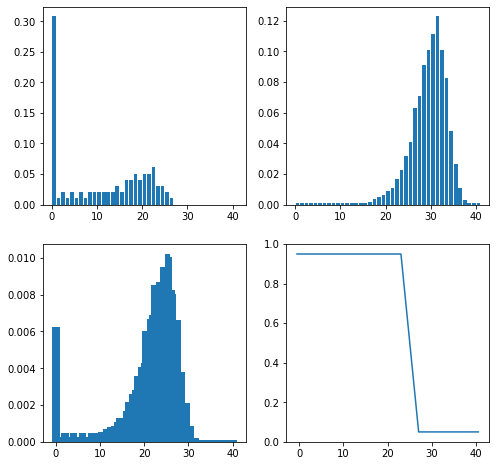

In [3]:
import pyvf.resources.turpin2003 as turpin2003
import importlib.resources as pkg_resources
from pyvf.stats import rv_histogram2
from pyvf.stats.pos import pos_ramp

with pkg_resources.open_text(turpin2003, "abnormal_pdf.csv") as f:
    abnormal_bins, abnormal_height = np.loadtxt(f, dtype=np.float32, delimiter=",", skiprows=0).T
    abnormal_bins = np.concatenate( (abnormal_bins - 0.5, [abnormal_bins[-1] + 0.5]) )
with pkg_resources.open_text(turpin2003, "normal_pdf.csv") as f:
    normal_bins, normal_height = np.loadtxt(f, dtype=np.float32, delimiter=",", skiprows=0).T
    normal_bins = np.concatenate((normal_bins - 0.5, [normal_bins[-1] + 0.5]))
    
refine_n = 10
hist_abnormal = rv_histogram2(histogram=(abnormal_height, abnormal_bins)).refined(refine_n)
hist_normal   = rv_histogram2(histogram=(  normal_height,   normal_bins)).refined(refine_n)
center_normal = hist_normal.mode()
epsilon = hist_normal.height.min()

def get_init_pdf(init_mean, coef_abnormal=0.2, coef_normal=0.8):
    return (coef_abnormal * hist_abnormal +
            coef_normal * hist_normal.roll(shift=int(round((init_mean - center_normal) * refine_n)), fill_value=epsilon))
    
fig, ax = plt.subplots(2, 2, sharex="row", sharey=False, figsize=[8, 8])
ax[0, 0].bar(abnormal_bins[1:], abnormal_height)
ax[0, 1].bar(normal_bins[1:], normal_height)
init_pdf = get_init_pdf(init_mean=25)
ax[1, 0].bar(init_pdf.bins[1:], init_pdf.height)
ax[1, 1].plot(init_pdf.bins, pos_ramp(init_pdf.bins, center=25, yl=0.95, yr=0.05, width=4))
ax[1, 1].set_ylim([0, 1])

hist_abnormal.entropy(), hist_normal.entropy(), init_pdf.entropy()

In [20]:
from pyvf.strategy import *
from pyvf.strategy.Model import *
from pyvf.strategy.Responder import *


def sim(strategy, responder):
    counter = 0
    data = []
    extras = {}
    extras["pdf"] = []
    while True:
        stimulus, threshold = strategy.get_stimulus_threshold(data)
        extras["pdf"].append(strategy.extra_data["pdf"])
        if stimulus is None:
            break  # Test is finished
        else:  # isinstance(stimulus, Stimulus):  # Single stimulus perimetry
            # _logger.extra_data("%3d: %s\t%s", counter, threshold, stimulus)
            if isinstance(stimulus, Stimulus):
                stimulus = stimulus.copy(**{TSDISP: counter})
                stimulus = responder.get_response(stimulus)
                data.append(stimulus)
            elif isinstance(stimulus[0], Stimulus):
                stimulus = [s.copy(**{TSDISP: counter}) for s in stimulus]
                stimulus = responder.get_response(stimulus)
                data.extend(stimulus)
            else:
                raise ValueError(f"Invalid stimulus object or list of stimuli: {stimulus}")
        counter += 1

    extras["counter"] = counter
    return data, extras

array([(3.,  3., 0, 0.43100706, 24.778702 , 0., 0., 0., 1),
       (3., -3., 1, 0.43100706, 24.778702 , 0., 1., 1., 1),
       (3., -3., 1, 0.43100706, 16.36965  , 0., 2., 2., 1),
       (3.,  3., 0, 0.43100706, 16.36965  , 0., 3., 3., 1),
       (3., -3., 1, 0.43100706,  6.84747  , 0., 4., 4., 1),
       (3., -3., 1, 0.43100706,  1.5903312, 0., 5., 5., 1),
       (3.,  3., 0, 0.43100706,  6.84747  , 0., 6., 6., 1),
       (3.,  3., 0, 0.43100706,  1.5903312, 0., 7., 7., 1)],
      dtype=[('xod', '<f4'), ('yod', '<f4'), ('loc', '<i4'), ('size', '<f4'), ('threshold', '<f4'), ('response', '<f4'), ('tsdisp', '<f4'), ('tsresp', '<f4'), ('multi', '<i4')])

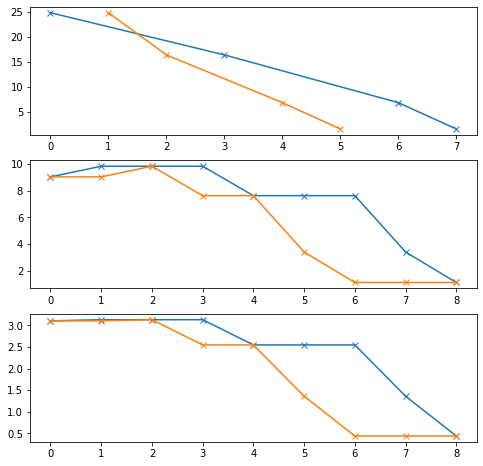

In [5]:
starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([0.0, 0.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case

responder = RampResponder(true_threshold=true_threshold, fp=0, fn=0, width=0.001)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
data, extras = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
idx = np.arange(len(data["threshold"]))
for m in range(2):
    ax[0].plot(idx[data["loc"]==m], data["threshold"][data["loc"]==m], "-x")
    ax[1].plot([i[m].std() for i in extras["pdf"]], "-x")
    ax[2].plot([i[m].entropy() for i in extras["pdf"]], "-x")

data

array([(3.,  3., 0, 0.43100706, 24.778702 , 0., 0., 0., 2),
       (3., -3., 1, 0.43100706, 24.778702 , 0., 0., 0., 2),
       (3., -3., 1, 0.43100706, 17.42009  , 0., 1., 1., 2),
       (3.,  3., 0, 0.43100706, 17.42009  , 0., 1., 1., 2),
       (3., -3., 1, 0.43100706,  8.883352 , 0., 2., 2., 2),
       (3.,  3., 0, 0.43100706,  8.883352 , 0., 2., 2., 2),
       (3.,  3., 0, 0.43100706,  2.9422503, 0., 3., 3., 2),
       (3., -3., 1, 0.43100706,  2.9422503, 0., 3., 3., 2),
       (3., -3., 1, 0.43100706,  0.6363673, 0., 4., 4., 2),
       (3.,  3., 0, 0.43100706,  0.6363673, 0., 4., 4., 2)],
      dtype=[('xod', '<f4'), ('yod', '<f4'), ('loc', '<i4'), ('size', '<f4'), ('threshold', '<f4'), ('response', '<f4'), ('tsdisp', '<f4'), ('tsresp', '<f4'), ('multi', '<i4')])

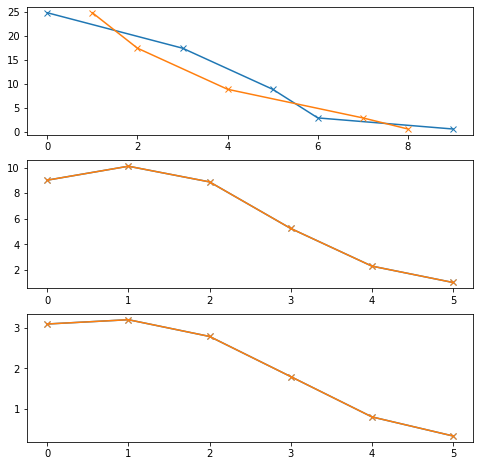

In [6]:
strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
data, extras = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
idx = np.arange(len(data["threshold"]))
for m in range(2):
    ax[0].plot(idx[data["loc"]==m], data["threshold"][data["loc"]==m], "-x")
    ax[1].plot([i[m].std() for i in extras["pdf"]], "-x")
    ax[2].plot([i[m].entropy() for i in extras["pdf"]], "-x")

data

True threshold = 10

array([(3.,  3., 0, 0.43100706, 24.778702, 0.,  0.,  0., 1),
       (3., -3., 1, 0.43100706, 24.778702, 0.,  1.,  1., 1),
       (3., -3., 1, 0.43100706, 16.36965 , 0.,  2.,  2., 1),
       (3.,  3., 0, 0.43100706, 16.36965 , 0.,  3.,  3., 1),
       (3., -3., 1, 0.43100706,  6.84747 , 1.,  4.,  4., 1),
       (3., -3., 1, 0.43100706, 13.569529, 0.,  5.,  5., 1),
       (3., -3., 1, 0.43100706,  9.704106, 1.,  6.,  6., 1),
       (3., -3., 1, 0.43100706, 12.088097, 0.,  7.,  7., 1),
       (3., -3., 1, 0.43100706, 10.655361, 0.,  8.,  8., 1),
       (3., -3., 1, 0.43100706,  9.64334 , 1.,  9.,  9., 1),
       (3.,  3., 0, 0.43100706,  6.84747 , 1., 10., 10., 1),
       (3.,  3., 0, 0.43100706, 13.569529, 0., 11., 11., 1),
       (3.,  3., 0, 0.43100706,  9.704106, 1., 12., 12., 1),
       (3.,  3., 0, 0.43100706, 12.088097, 0., 13., 13., 1),
       (3.,  3., 0, 0.43100706, 10.655361, 0., 14., 14., 1),
       (3.,  3., 0, 0.43100706,  9.64334 , 1., 15., 15., 1)],
      dtype=[('xod', '<

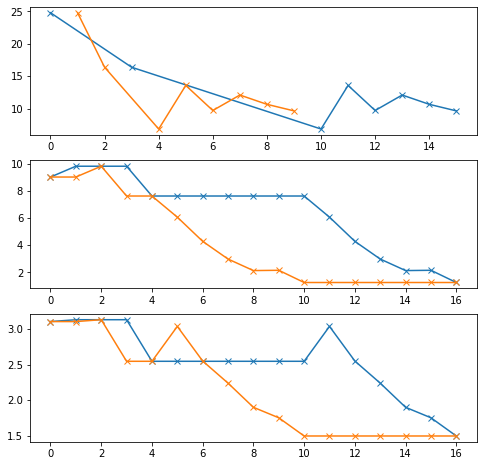

In [7]:
starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([10.0, 10.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case

responder = RampResponder(true_threshold=true_threshold, fp=0, fn=0, width=0.001)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
data, extras = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
idx = np.arange(len(data["threshold"]))
for m in range(2):
    ax[0].plot(idx[data["loc"]==m], data["threshold"][data["loc"]==m], "-x")
    ax[1].plot([i[m].std() for i in extras["pdf"]], "-x")
    ax[2].plot([i[m].entropy() for i in extras["pdf"]], "-x")

data

array([(3.,  3., 0, 0.43100706, 24.778702 , 0.,  0.,  0., 2),
       (3., -3., 1, 0.43100706, 24.778702 , 0.,  0.,  0., 2),
       (3., -3., 1, 0.43100706, 17.42009  , 0.,  1.,  1., 2),
       (3.,  3., 0, 0.43100706, 17.42009  , 0.,  1.,  1., 2),
       (3., -3., 1, 0.43100706,  8.883352 , 1.,  2.,  2., 2),
       (3.,  3., 0, 0.43100706,  8.883352 , 1.,  2.,  2., 2),
       (3.,  3., 0, 0.43100706, 11.331806 , 0.,  3.,  3., 2),
       (3., -3., 1, 0.43100706, 11.331806 , 0.,  3.,  3., 2),
       (3., -3., 1, 0.43100706,  4.8569574, 1.,  4.,  4., 2),
       (3.,  3., 0, 0.43100706,  4.8569574, 1.,  4.,  4., 2),
       (3., -3., 1, 0.43100706,  6.554261 , 1.,  5.,  5., 2),
       (3.,  3., 0, 0.43100706,  6.554261 , 1.,  5.,  5., 2),
       (3., -3., 1, 0.43100706,  8.245248 , 1.,  6.,  6., 2),
       (3.,  3., 0, 0.43100706,  8.245248 , 1.,  6.,  6., 2),
       (3., -3., 1, 0.43100706,  9.805555 , 1.,  7.,  7., 2),
       (3.,  3., 0, 0.43100706,  9.805555 , 1.,  7.,  7., 2),
       (

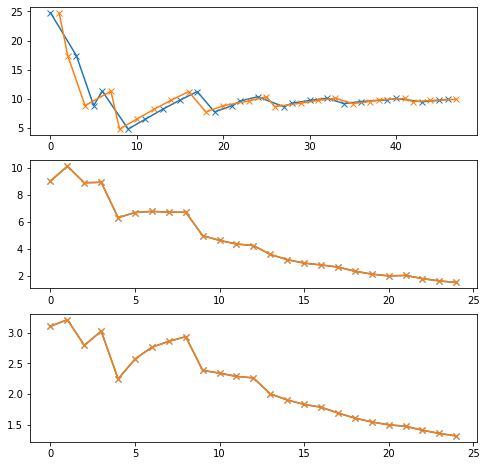

In [8]:
strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
data, extras = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
idx = np.arange(len(data["threshold"]))
for m in range(2):
    ax[0].plot(idx[data["loc"]==m], data["threshold"][data["loc"]==m], "-x")
    ax[1].plot([i[m].std() for i in extras["pdf"]], "-x")
    ax[2].plot([i[m].entropy() for i in extras["pdf"]], "-x")

data

array([(3.,  3., 0, 0.43100706, 25.278702 , 0.,  0.,  0., 2),
       (3., -3., 1, 0.43100706, 25.278702 , 0.,  0.,  0., 2),
       (3., -3., 1, 0.43100706, 18.319826 , 0.,  1.,  1., 2),
       (3.,  3., 0, 0.43100706, 18.319826 , 0.,  1.,  1., 2),
       (3., -3., 1, 0.43100706, 10.099702 , 0.,  2.,  2., 2),
       (3.,  3., 0, 0.43100706, 10.099702 , 0.,  2.,  2., 2),
       (3.,  3., 0, 0.43100706,  3.949573 , 1.,  3.,  3., 2),
       (3., -3., 1, 0.43100706,  3.949573 , 1.,  3.,  3., 2),
       (3., -3., 1, 0.43100706,  5.404308 , 1.,  4.,  4., 2),
       (3.,  3., 0, 0.43100706,  5.404308 , 1.,  4.,  4., 2),
       (3., -3., 1, 0.43100706,  7.011773 , 1.,  5.,  5., 2),
       (3.,  3., 0, 0.43100706,  7.011773 , 1.,  5.,  5., 2),
       (3., -3., 1, 0.43100706,  8.659426 , 1.,  6.,  6., 2),
       (3.,  3., 0, 0.43100706,  8.659426 , 1.,  6.,  6., 2),
       (3., -3., 1, 0.43100706, 10.3248625, 0.,  7.,  7., 2),
       (3.,  3., 0, 0.43100706, 10.3248625, 0.,  7.,  7., 2),
       (

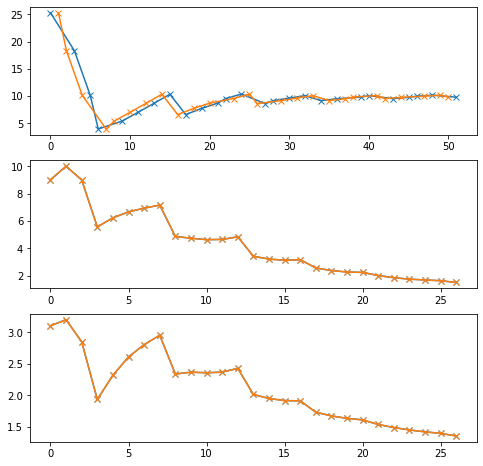

In [9]:
strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern(),
    msp_threshold_offset={1: 0, 2: +0.5}
)
data, extras = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
idx = np.arange(len(data["threshold"]))
for m in range(2):
    ax[0].plot(idx[data["loc"]==m], data["threshold"][data["loc"]==m], "-x")
    ax[1].plot([i[m].std() for i in extras["pdf"]], "-x")
    ax[2].plot([i[m].entropy() for i in extras["pdf"]], "-x")

data

True threshold = 30

array([(3.,  3., 0, 0.43100706, 24.778702, 1., 0., 0., 1),
       (3., -3., 1, 0.43100706, 24.778702, 1., 1., 1., 1),
       (3., -3., 1, 0.43100706, 29.311897, 1., 2., 2., 1),
       (3.,  3., 0, 0.43100706, 29.311897, 1., 3., 3., 1),
       (3., -3., 1, 0.43100706, 31.304636, 0., 4., 4., 1),
       (3., -3., 1, 0.43100706, 30.114553, 0., 5., 5., 1),
       (3., -3., 1, 0.43100706, 29.223124, 1., 6., 6., 1),
       (3.,  3., 0, 0.43100706, 31.304636, 0., 7., 7., 1),
       (3.,  3., 0, 0.43100706, 30.114553, 0., 8., 8., 1),
       (3.,  3., 0, 0.43100706, 29.223124, 1., 9., 9., 1)],
      dtype=[('xod', '<f4'), ('yod', '<f4'), ('loc', '<i4'), ('size', '<f4'), ('threshold', '<f4'), ('response', '<f4'), ('tsdisp', '<f4'), ('tsresp', '<f4'), ('multi', '<i4')])

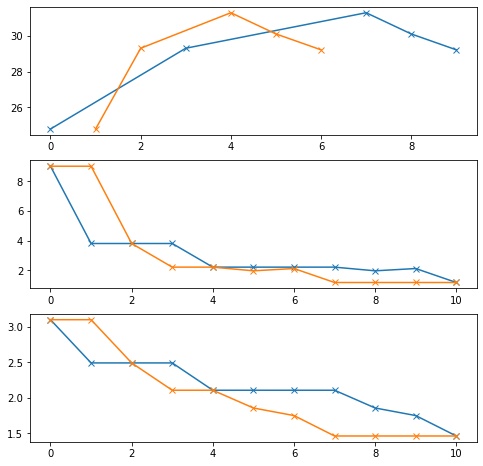

In [10]:
starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([30.0, 30.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case

responder = RampResponder(true_threshold=true_threshold, fp=0, fn=0, width=0.001)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
data, extras = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
idx = np.arange(len(data["threshold"]))
for m in range(2):
    ax[0].plot(idx[data["loc"]==m], data["threshold"][data["loc"]==m], "-x")
    ax[1].plot([i[m].std() for i in extras["pdf"]], "-x")
    ax[2].plot([i[m].entropy() for i in extras["pdf"]], "-x")

data

array([(3.,  3., 0, 0.43100706, 24.778702, 1.,  0.,  0., 2),
       (3., -3., 1, 0.43100706, 24.778702, 1.,  0.,  0., 2),
       (3., -3., 1, 0.43100706, 26.619867, 1.,  1.,  1., 2),
       (3.,  3., 0, 0.43100706, 26.619867, 1.,  1.,  1., 2),
       (3., -3., 1, 0.43100706, 28.023285, 1.,  2.,  2., 2),
       (3.,  3., 0, 0.43100706, 28.023285, 1.,  2.,  2., 2),
       (3.,  3., 0, 0.43100706, 29.106274, 1.,  3.,  3., 2),
       (3., -3., 1, 0.43100706, 29.106274, 1.,  3.,  3., 2),
       (3., -3., 1, 0.43100706, 29.963682, 1.,  4.,  4., 2),
       (3.,  3., 0, 0.43100706, 29.963682, 1.,  4.,  4., 2),
       (3., -3., 1, 0.43100706, 30.66492 , 0.,  5.,  5., 2),
       (3.,  3., 0, 0.43100706, 30.66492 , 0.,  5.,  5., 2),
       (3., -3., 1, 0.43100706, 28.829294, 1.,  6.,  6., 2),
       (3.,  3., 0, 0.43100706, 28.829294, 1.,  6.,  6., 2),
       (3., -3., 1, 0.43100706, 29.501678, 1.,  7.,  7., 2),
       (3.,  3., 0, 0.43100706, 29.501678, 1.,  7.,  7., 2),
       (3., -3., 1, 0.43

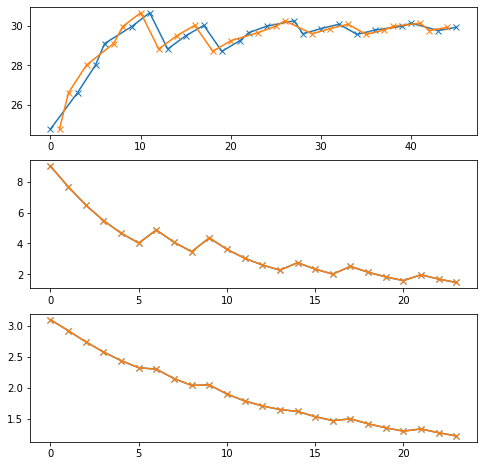

In [11]:
strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
data, extras = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(3, 1, figsize=[8, 8])
idx = np.arange(len(data["threshold"]))
for m in range(2):
    ax[0].plot(idx[data["loc"]==m], data["threshold"][data["loc"]==m], "-x")
    ax[1].plot([i[m].std() for i in extras["pdf"]], "-x")
    ax[2].plot([i[m].entropy() for i in extras["pdf"]], "-x")

data

SSP vs MSP accuracy


In [61]:
starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([0.0, 0.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case
responder = RampResponder(true_threshold=true_threshold, fp=0.05, fn=0.05, width=4, seed=0)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
threshold_estimates_ssp = []
threshold_presentations_ssp = []
threshold_estimates_msp = []
threshold_presentations_msp = []
for i in range(50):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_ssp.append(threshold)
    threshold_presentations_ssp.append(extras["counter"])


strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=2.0,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
for i in range(50):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_msp.append(threshold)
    threshold_presentations_msp.append(extras["counter"])

threshold_estimates_ssp = np.array(threshold_estimates_ssp)
threshold_presentations_ssp = np.array(threshold_presentations_ssp)
threshold_estimates_msp = np.array(threshold_estimates_msp)
threshold_presentations_msp = np.array(threshold_presentations_msp)

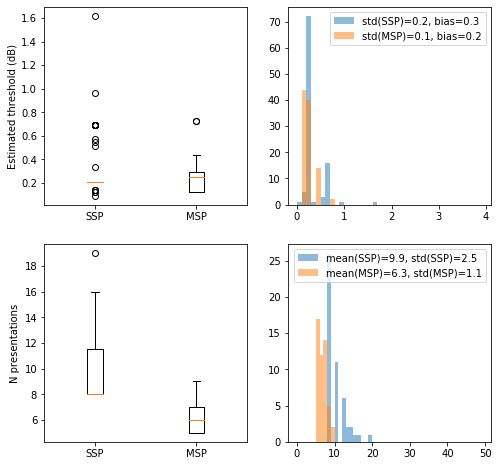

In [62]:
fig, ax = plt.subplots(2, 2, figsize=[8, 8])
ax[0, 0].boxplot([threshold_estimates_ssp.ravel(), threshold_estimates_msp.ravel()], labels=["SSP", "MSP"])
ax[0, 0].set_ylabel("Estimated threshold (dB)")
ax[1, 0].boxplot([threshold_presentations_ssp, threshold_presentations_msp], labels=["SSP", "MSP"])
ax[1, 0].set_ylabel("N presentations")
ax[0, 1].hist(threshold_estimates_ssp.ravel(), bins=np.arange(0, 4, 0.1), alpha=0.5, label=f"std(SSP)={threshold_estimates_ssp.std():.1f}, bias={threshold_estimates_ssp.mean()-0:.1f}")
ax[0, 1].hist(threshold_estimates_msp.ravel(), bins=np.arange(0, 4, 0.1), alpha=0.5, label=f"std(MSP)={threshold_estimates_msp.std():.1f}, bias={threshold_estimates_msp.mean()-0:.1f}")
ax[0, 1].legend()
ax[1, 1].hist(threshold_presentations_ssp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(SSP)={threshold_presentations_ssp.mean():.1f}, std(SSP)={threshold_presentations_ssp.std():.1f}")
ax[1, 1].hist(threshold_presentations_msp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(MSP)={threshold_presentations_msp.mean():.1f}, std(MSP)={threshold_presentations_msp.std():.1f}")
ax[1, 1].legend()

In [59]:
starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([10.0, 10.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case
responder = RampResponder(true_threshold=true_threshold, fp=0.05, fn=0.05, width=4, seed=0)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
threshold_estimates_ssp = []
threshold_presentations_ssp = []
threshold_estimates_msp = []
threshold_presentations_msp = []
for i in range(100):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_ssp.append(threshold)
    threshold_presentations_ssp.append(extras["counter"])


strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=2.0,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
for i in range(100):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_msp.append(threshold)
    threshold_presentations_msp.append(extras["counter"])

threshold_estimates_ssp = np.array(threshold_estimates_ssp)
threshold_presentations_ssp = np.array(threshold_presentations_ssp)
threshold_estimates_msp = np.array(threshold_estimates_msp)
threshold_presentations_msp = np.array(threshold_presentations_msp)

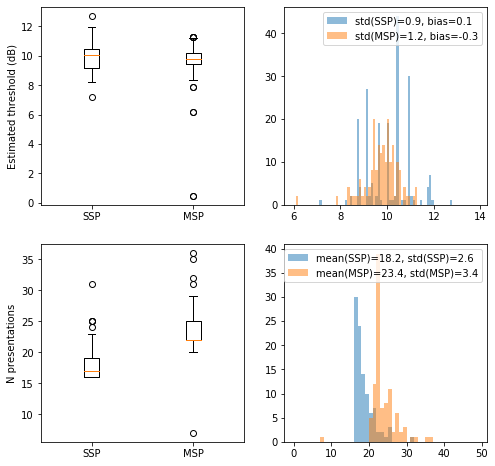

In [60]:
fig, ax = plt.subplots(2, 2, figsize=[8, 8])
ax[0, 0].boxplot([threshold_estimates_ssp.ravel(), threshold_estimates_msp.ravel()], labels=["SSP", "MSP"])
ax[0, 0].set_ylabel("Estimated threshold (dB)")
ax[1, 0].boxplot([threshold_presentations_ssp, threshold_presentations_msp], labels=["SSP", "MSP"])
ax[1, 0].set_ylabel("N presentations")
ax[0, 1].hist(threshold_estimates_ssp.ravel(), bins=np.arange(6, 14, 0.1), alpha=0.5, label=f"std(SSP)={threshold_estimates_ssp.std():.1f}, bias={threshold_estimates_ssp.mean()-10:.1f}")
ax[0, 1].hist(threshold_estimates_msp.ravel(), bins=np.arange(6, 14, 0.1), alpha=0.5, label=f"std(MSP)={threshold_estimates_msp.std():.1f}, bias={threshold_estimates_msp.mean()-10:.1f}")
ax[0, 1].legend()
ax[1, 1].hist(threshold_presentations_ssp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(SSP)={threshold_presentations_ssp.mean():.1f}, std(SSP)={threshold_presentations_ssp.std():.1f}")
ax[1, 1].hist(threshold_presentations_msp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(MSP)={threshold_presentations_msp.mean():.1f}, std(MSP)={threshold_presentations_msp.std():.1f}")
ax[1, 1].legend()


In [71]:
starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([30.0, 30.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case
responder = RampResponder(true_threshold=true_threshold, fp=0.05, fn=0.05, width=4, seed=0)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
threshold_estimates_ssp = []
threshold_presentations_ssp = []
threshold_estimates_msp = []
threshold_presentations_msp = []
for i in range(100):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_ssp.append(threshold)
    threshold_presentations_ssp.append(extras["counter"])


strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=2.0,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
for i in range(100):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_msp.append(threshold)
    threshold_presentations_msp.append(extras["counter"])

threshold_estimates_ssp = np.array(threshold_estimates_ssp)
threshold_presentations_ssp = np.array(threshold_presentations_ssp)
threshold_estimates_msp = np.array(threshold_estimates_msp)
threshold_presentations_msp = np.array(threshold_presentations_msp)

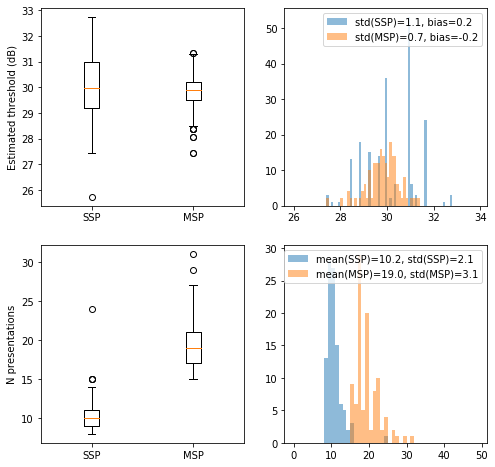

In [72]:
fig, ax = plt.subplots(2, 2, figsize=[8, 8])
ax[0, 0].boxplot([threshold_estimates_ssp.ravel(), threshold_estimates_msp.ravel()], labels=["SSP", "MSP"])
ax[0, 0].set_ylabel("Estimated threshold (dB)")
ax[1, 0].boxplot([threshold_presentations_ssp, threshold_presentations_msp], labels=["SSP", "MSP"])
ax[1, 0].set_ylabel("N presentations")
ax[0, 1].hist(threshold_estimates_ssp.ravel(), bins=np.arange(true_threshold[0]-4, true_threshold[0]+4, 0.1), alpha=0.5, label=f"std(SSP)={threshold_estimates_ssp.std():.1f}, bias={threshold_estimates_ssp.mean()-true_threshold[0]:.1f}")
ax[0, 1].hist(threshold_estimates_msp.ravel(), bins=np.arange(true_threshold[0]-4, true_threshold[0]+4, 0.1), alpha=0.5, label=f"std(MSP)={threshold_estimates_msp.std():.1f}, bias={threshold_estimates_msp.mean()-true_threshold[0]:.1f}")
ax[0, 1].legend()
ax[1, 1].hist(threshold_presentations_ssp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(SSP)={threshold_presentations_ssp.mean():.1f}, std(SSP)={threshold_presentations_ssp.std():.1f}")
ax[1, 1].hist(threshold_presentations_msp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(MSP)={threshold_presentations_msp.mean():.1f}, std(MSP)={threshold_presentations_msp.std():.1f}")
ax[1, 1].legend()

In [81]:
starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([0.0, 20.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case
responder = RampResponder(true_threshold=true_threshold, fp=0.05, fn=0.05, width=4, seed=0)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
threshold_estimates_ssp = []
threshold_presentations_ssp = []
threshold_estimates_msp = []
threshold_presentations_msp = []
for i in range(100):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_ssp.append(threshold)
    threshold_presentations_ssp.append(extras["counter"])


strategy = ZestMSPStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=2.0,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
for i in range(100):
    data, extras = sim(strategy, responder)
    stimulus, threshold = strategy.get_stimulus_threshold(data)
    assert stimulus is None
    threshold_estimates_msp.append(threshold)
    threshold_presentations_msp.append(extras["counter"])

threshold_estimates_ssp = np.array(threshold_estimates_ssp)
threshold_presentations_ssp = np.array(threshold_presentations_ssp)
threshold_estimates_msp = np.array(threshold_estimates_msp)
threshold_presentations_msp = np.array(threshold_presentations_msp)



KeyboardInterrupt: 

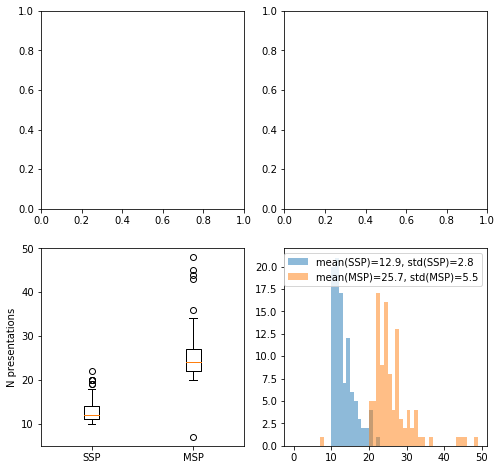

In [79]:
fig, ax = plt.subplots(2, 2, figsize=[8, 8])
# ax[0, 0].boxplot([threshold_estimates_ssp.ravel(), threshold_estimates_msp.ravel()], labels=["SSP", "MSP"])
# ax[0, 0].set_ylabel("Estimated threshold (dB)")
ax[1, 0].boxplot([threshold_presentations_ssp, threshold_presentations_msp], labels=["SSP", "MSP"])
ax[1, 0].set_ylabel("N presentations")
# ax[0, 1].hist(threshold_estimates_ssp.ravel(), bins=np.arange(true_threshold[0]-4, true_threshold[0]+4, 0.1), alpha=0.5, label=f"std(SSP)={threshold_estimates_ssp.std():.1f}, bias={threshold_estimates_ssp.mean()-true_threshold[0]:.1f}")
# ax[0, 1].hist(threshold_estimates_msp.ravel(), bins=np.arange(true_threshold[0]-4, true_threshold[0]+4, 0.1), alpha=0.5, label=f"std(MSP)={threshold_estimates_msp.std():.1f}, bias={threshold_estimates_msp.mean()-true_threshold[0]:.1f}")
# ax[0, 1].legend()
ax[1, 1].hist(threshold_presentations_ssp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(SSP)={threshold_presentations_ssp.mean():.1f}, std(SSP)={threshold_presentations_ssp.std():.1f}")
ax[1, 1].hist(threshold_presentations_msp.ravel(), bins=np.arange(0, 50, 1), alpha=0.5, label=f"mean(MSP)={threshold_presentations_msp.mean():.1f}, std(MSP)={threshold_presentations_msp.std():.1f}")
ax[1, 1].legend()



In [80]:

data

[Stimulus(xod=3.0, yod=-3.0, loc=1, size=0.43100706, threshold=24.77870190489339, response=0, tsdisp=0, tsresp=0, multi=2),
 Stimulus(xod=3.0, yod=3.0, loc=0, size=0.43100706, threshold=24.77870190489339, response=0, tsdisp=0, tsresp=0, multi=2),
 Stimulus(xod=3.0, yod=3.0, loc=0, size=0.43100706, threshold=17.42009037563985, response=1, tsdisp=1, tsresp=1, multi=2),
 Stimulus(xod=3.0, yod=-3.0, loc=1, size=0.43100706, threshold=17.42009037563985, response=1, tsdisp=1, tsresp=1, multi=2),
 Stimulus(xod=3.0, yod=-3.0, loc=1, size=0.43100706, threshold=19.840926532575395, response=1, tsdisp=2, tsresp=2, multi=2),
 Stimulus(xod=3.0, yod=3.0, loc=0, size=0.43100706, threshold=19.840926532575395, response=1, tsdisp=2, tsresp=2, multi=2),
 Stimulus(xod=3.0, yod=3.0, loc=0, size=0.43100706, threshold=21.76912210461684, response=0, tsdisp=3, tsresp=3, multi=2),
 Stimulus(xod=3.0, yod=-3.0, loc=1, size=0.43100706, threshold=21.76912210461684, response=0, tsdisp=3, tsresp=3, multi=2),
 Stimulus(